# Analysing a proteomics data set using lgpr
Here we analyse one protein from a published longitudinal proteomics data set (Liu *et al.*, 2018).

In [1]:
require(lgpr)
require(repr)
require(ggplot2)

dataDir <-  "../data/proteomics/"  # Set path to data here
i_prot  <- 450                     # Set protein idx (1-1538) here

Loading required package: lgpr

Hello, this is lgpr (version 0.27.4).

Loading required package: repr

Loading required package: ggplot2



## 1. Data loading
The code below loads and visualizes the data.

Read data for protein 'O94769'. 
Removed 9 rows with NaN value for the response variable.


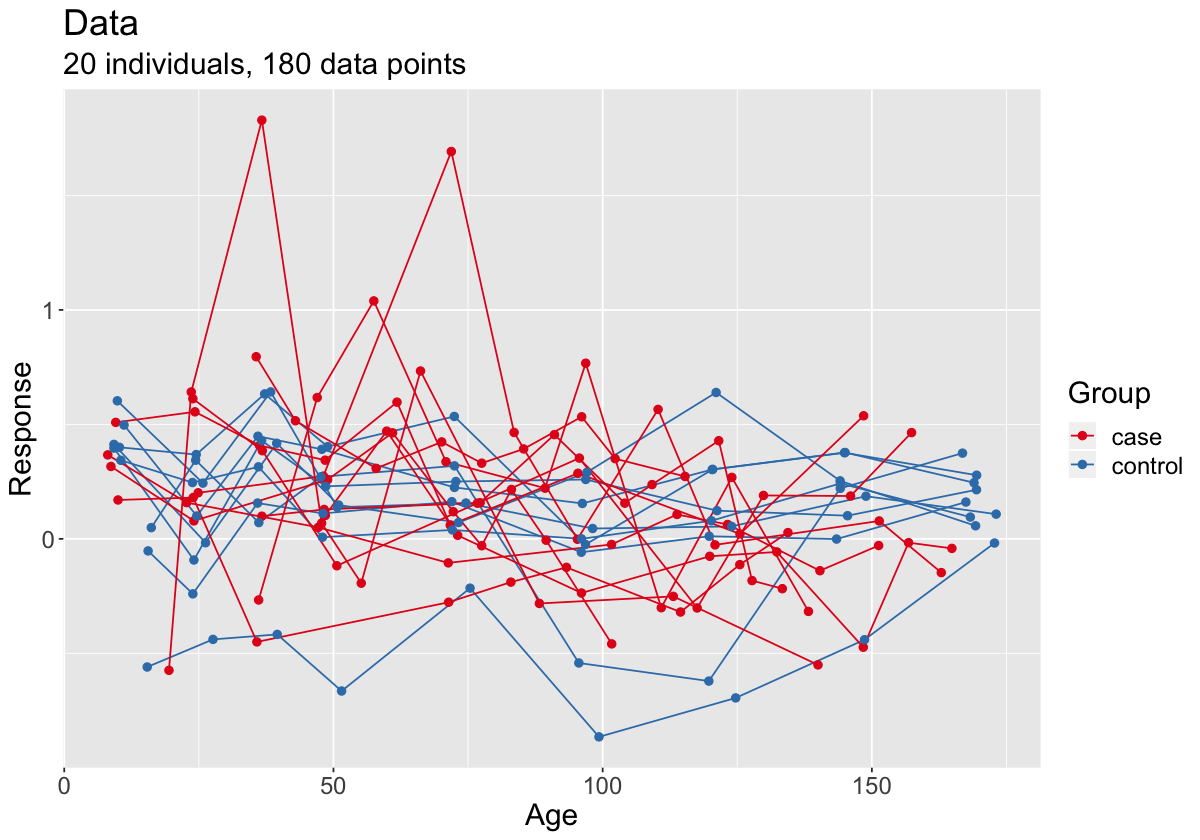

In [2]:
readLiuData <- function(dataDir, protein){
  fn_X   <- paste(dataDir,"/liu_preproc_X.csv",sep="")
  fn_Y   <- paste(dataDir,"/liu_preproc_Y.csv",sep="")
  X_data <- read.csv(fn_X, header=TRUE, sep=",")
  X_data <- X_data[,1:5]
  Y_data <- read.csv(fn_Y, header=TRUE, sep=",")
  names  <- colnames(Y_data)
  if(!is.character(protein)){
    pname <- names[protein]
  }else{
    pname <- protein
  }
  
  cat("Read data for protein '", pname, "'. \n", sep = "")
  y      <- Y_data[[pname]]
  notnan <- which(!is.nan(y))
  n_nan  <- length(which(is.nan(y)))
  data   <- data.frame(cbind(X_data, y))
  data   <- data[notnan, ]
  cat("Removed ", n_nan , " rows with NaN value for the response variable.\n", sep = "")
  return(data)
}


FONT_SIZE <- 18
options(repr.plot.width=10, repr.plot.height=7)
data <- readLiuData(dataDir, i_prot)
plot0 <- plot_data(data, highlight = 'disease') + theme(text=element_text(size=FONT_SIZE))
plot0

## 2. Homogeneous disease effect modeling
We first fit a model where the possible disease effect has to be identical for all diagnosed individuals. 

In [3]:
CNTR     <- list(adapt_delta = 0.95)                # set the adapt_delta parameter for dynamic HMC sampling
my_prior <- prior_LonGP()                           # initialize parameter prior
my_prior$lengthscale <- prior_default()$lengthscale # change the prior of lengthscale parameters


fit1 <- lgp(formula      = y ~ id + age + diseaseAge + sex + group,
            data         = data,
            prior        = my_prior,
            offset_vars  = "group",
            control      = CNTR,
            iter         = 2000,
            equal_effect = TRUE,
            chains       = 4,
            parallel     = TRUE,
            save_warmup  = FALSE,
            refresh      = 0,
            verbose      = TRUE)

* Interpreting 'diseaseAge' as the disease-related age variable.
* Covariate 'sex' resolved to type 'categorical'.

 ---------- LGPMODEL SUMMARY ----------

  Model:
    f = f[(1)](id, age) + f[(2)](age) + f[(3)](diseaseAge) + f[(4)](sex, age) + f[(5)](group)
    Response variable: y
    Observation model: Gaussian 
  Variable types:
    - Identifier variable: id
    - Time variable: age
    - Disease-related age variable: diseaseAge
    - Other categorical variables: sex
    - Group offset variables: group
  Observation model: Gaussian
  Disease component 
    - Effect time: fixed
    - Effect type: homogeneous

 ---------- PRIOR SPECIFICATIONS ----------

  alpha_id ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_age ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_diseaseAge ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categOffset ~ Student-t(nu=4,mu=0,sigma=1)

  ell_id ~ Log-Normal(0,1.151)
  ell_age ~ Log-Normal(0,1.151)
  ell_diseaseAge ~ Log-Normal(0,

The covariate relevances are reported above. We can visualize the inferred components.

* Computing predictions using MAP parameters. 


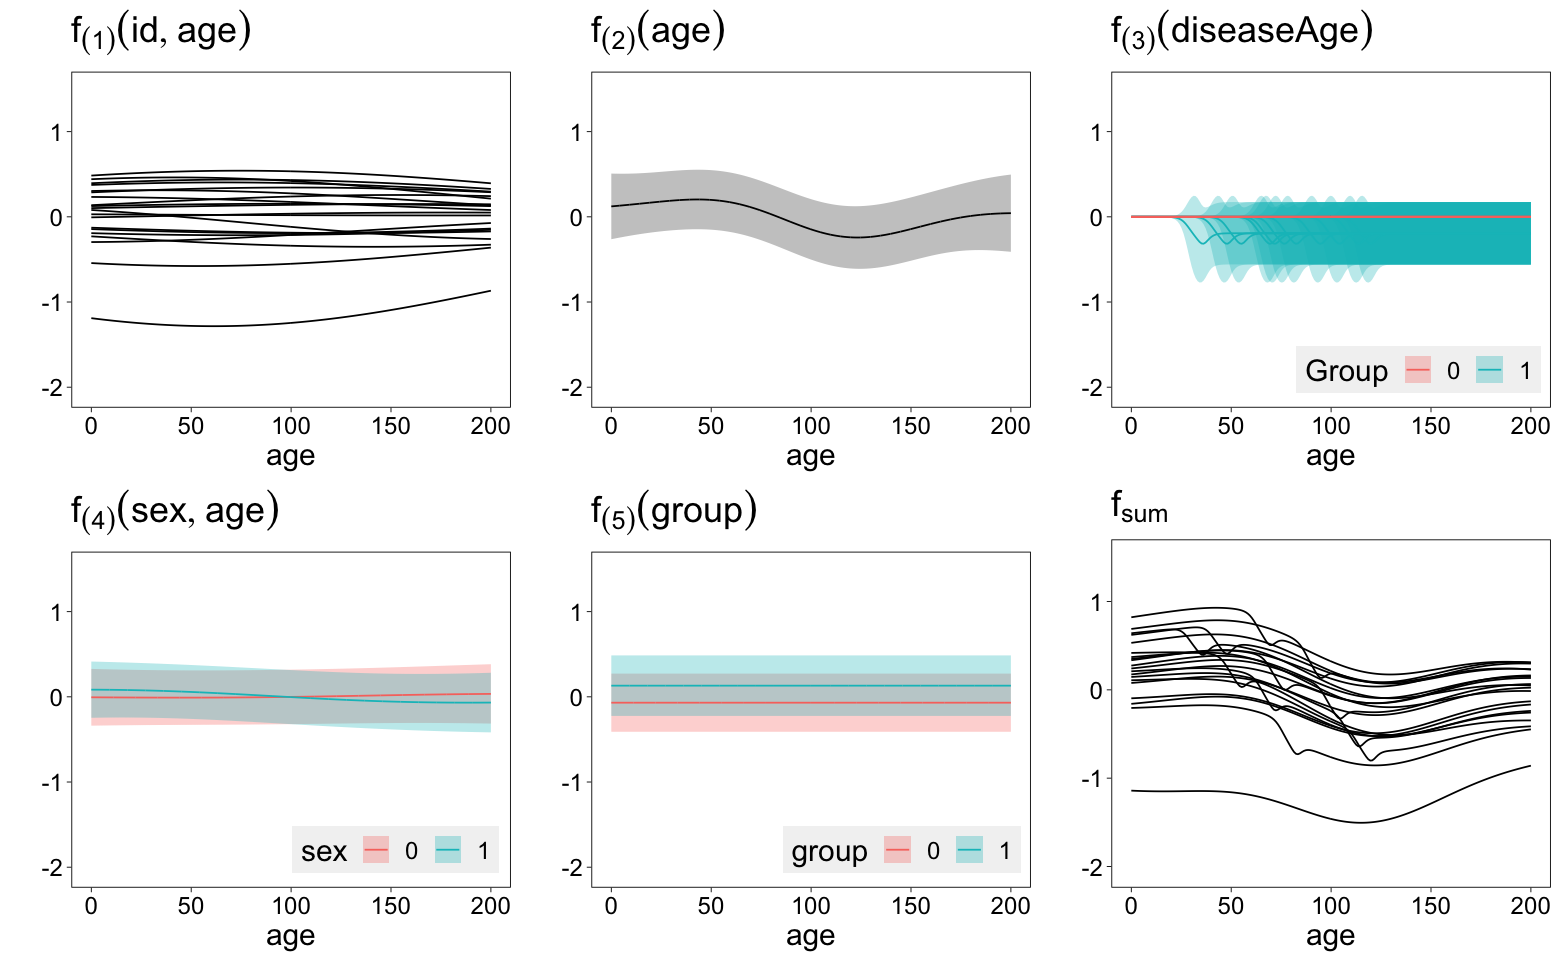

In [4]:
FONT_SIZE <- 18
options(repr.plot.width=13, repr.plot.height=8) 
ttt    <- seq(0, 200, length.out = 200)
X_pred <- create_test_points(fit1, ttt)
PRED1  <- lgp_predict(fit1, X_pred)
plot1a <- plot_components_posterior(fit1, PRED=PRED1, font_size = FONT_SIZE)
plot1a

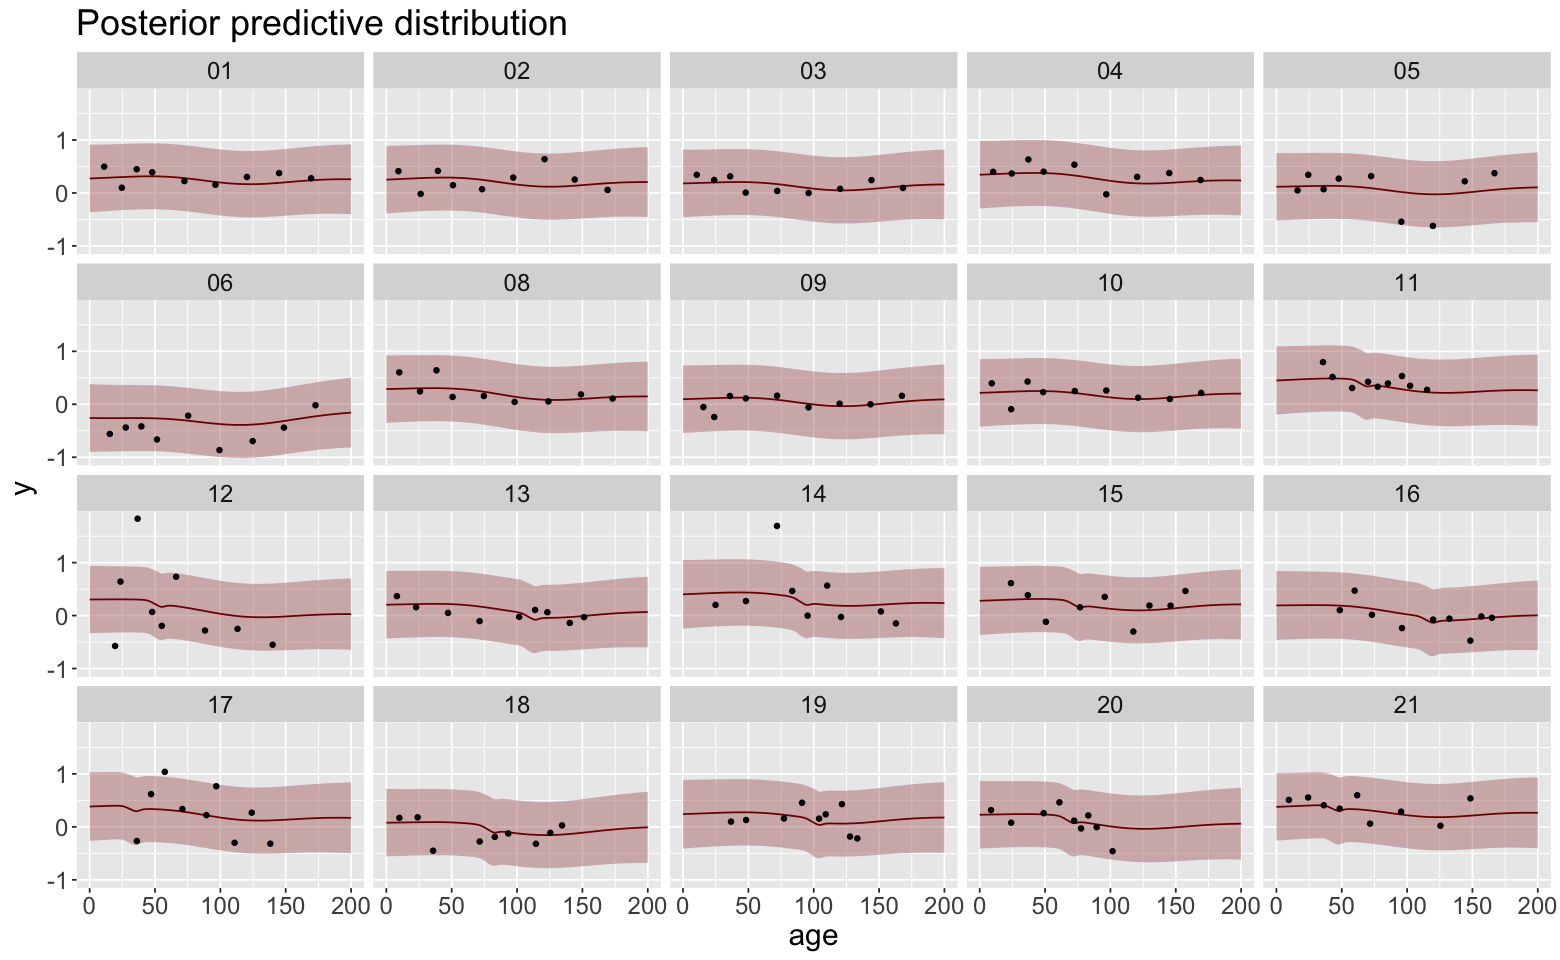

In [5]:
plot1b <- plot_posterior_y(fit1, PRED=PRED1) + theme(text=element_text(size=FONT_SIZE))
plot1b

## 3. Heterogeneous disease effect modeling
Next we fit a model where the magnitude of a possible disease effect can vary over diagnosed individuals (this will take longer to run).

In [6]:
fit2 <- lgp(formula      = y ~ id + age + diseaseAge + sex + group,
            data         = data,
            prior        = my_prior,
            offset_vars  = "group",
            control      = CNTR,
            iter         = 2000,
            equal_effect = FALSE,
            chains       = 4,
            parallel     = TRUE,
            save_warmup  = FALSE,
            refresh      = 0,
            verbose      = TRUE)


print(fit2)

* Interpreting 'diseaseAge' as the disease-related age variable.
* Covariate 'sex' resolved to type 'categorical'.

 ---------- LGPMODEL SUMMARY ----------

  Model:
    f = f[(1)](id, age) + f[(2)](age) + f[(3)](diseaseAge) + f[(4)](sex, age) + f[(5)](group)
    Response variable: y
    Observation model: Gaussian 
  Variable types:
    - Identifier variable: id
    - Time variable: age
    - Disease-related age variable: diseaseAge
    - Other categorical variables: sex
    - Group offset variables: group
  Observation model: Gaussian
  Disease component 
    - Effect time: fixed
    - Effect type: heterogeneous

 ---------- PRIOR SPECIFICATIONS ----------

  alpha_id ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_age ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_diseaseAge ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categOffset ~ Student-t(nu=4,mu=0,sigma=1)

  ell_id ~ Log-Normal(0,1.151)
  ell_age ~ Log-Normal(0,1.151)
  ell_diseaseAge ~ Log-Normal(

Warning message:
“The largest R-hat is 1.08, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


* Begin postprocessing. 
* Computing relevances over 4000 posterior samples.

* The following components explain 96.27% of variance: {noise, f[(1)](id, age), f[(3)](diseaseAge)}.

 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 1514.02 s (warmup) and 463.63 s (sampling)
* The largest R_hat value (ignoring generated quantities) is 1.205 (warp_steepness[1]).
* Proportion of signal = 0.559
* Selection threshold = 0.95

                   Relevance Selected
f[(1)](id, age)        0.272     TRUE
f[(2)](age)            0.032    FALSE
f[(3)](diseaseAge)     0.250     TRUE
f[(4)](sex, age)       0.003    FALSE
f[(5)](group)          0.002    FALSE
noise                  0.441     TRUE


 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 1514.02 s (warmup) and 463.63 s (sampling)
* The largest R_hat value (ignoring generated quantities) is 1.205 (warp_steepness[1]).
* Proportion of signal = 0.559
* Selection threshold = 0.95

                   Relevance Sel

As we see, the relevance of the `diseaseAge` covariate is now higher than for the homogeneous model. Visualization of inferred effects reveals that only part of the individuals experience a strong disease effect near the time of seroconversion.

* Computing predictions using MAP parameters. 


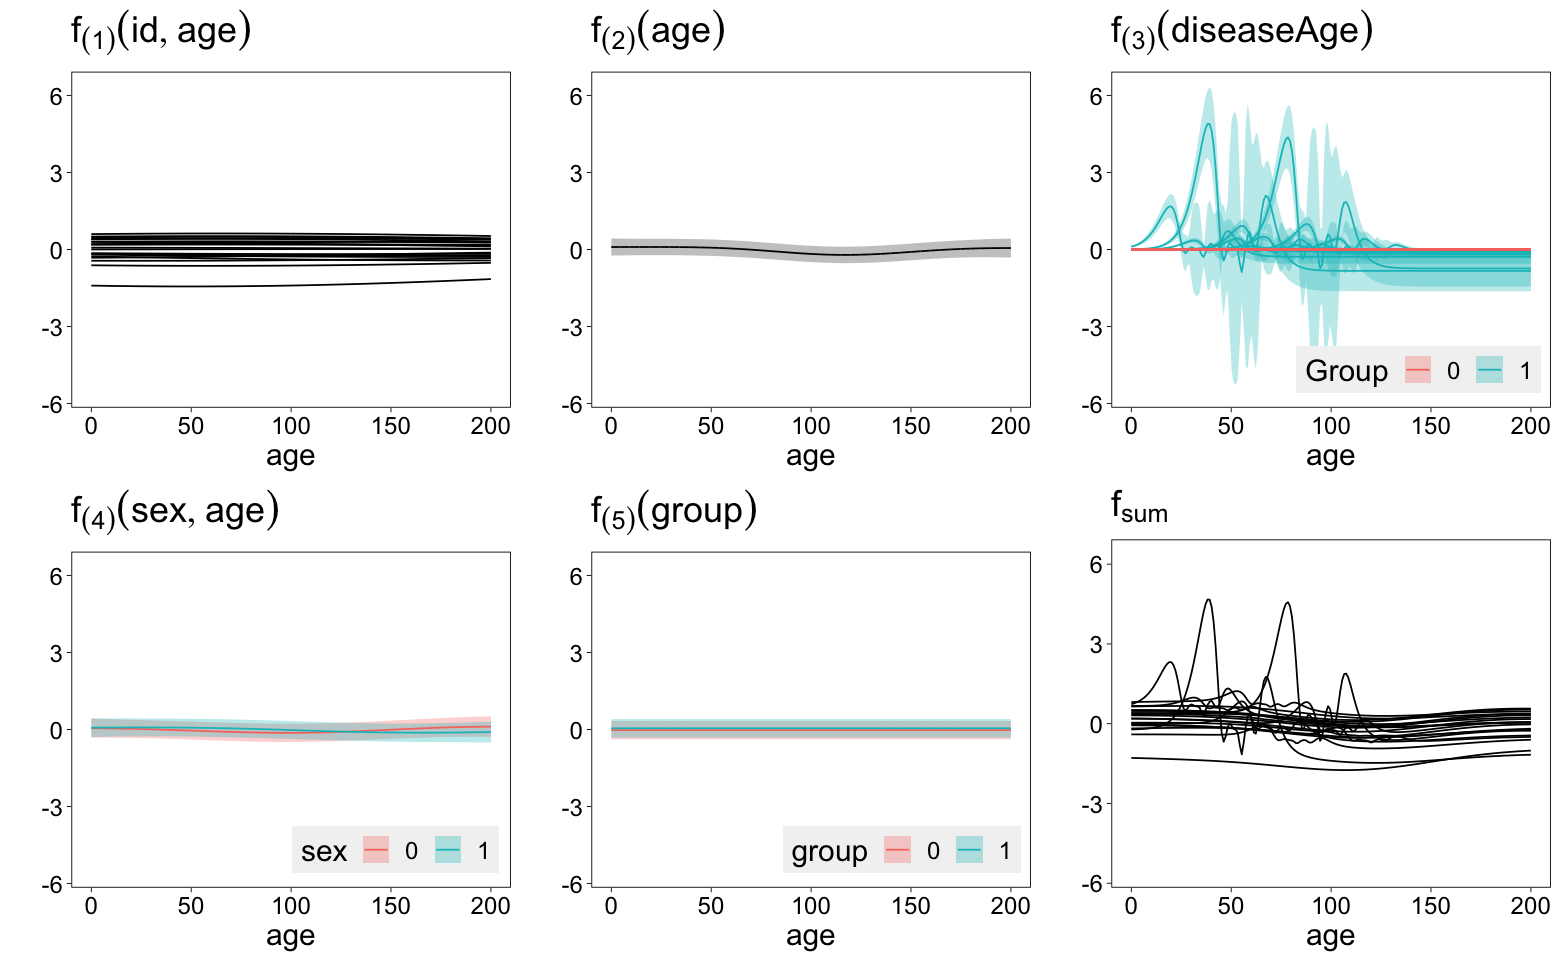

In [10]:
FONT_SIZE <- 18
options(repr.plot.width=13, repr.plot.height=8) 
ttt    <- seq(0, 200, length.out = 200)
X_pred <- create_test_points(fit2, ttt)
PRED2  <- lgp_predict(fit2, X_pred)
plot2a <- plot_components_posterior(fit2, PRED=PRED2, font_size = FONT_SIZE)
plot2a

The posterior distribution of the $\beta$ parameters reveals two individuals with a large disease effect near seroconversion time.

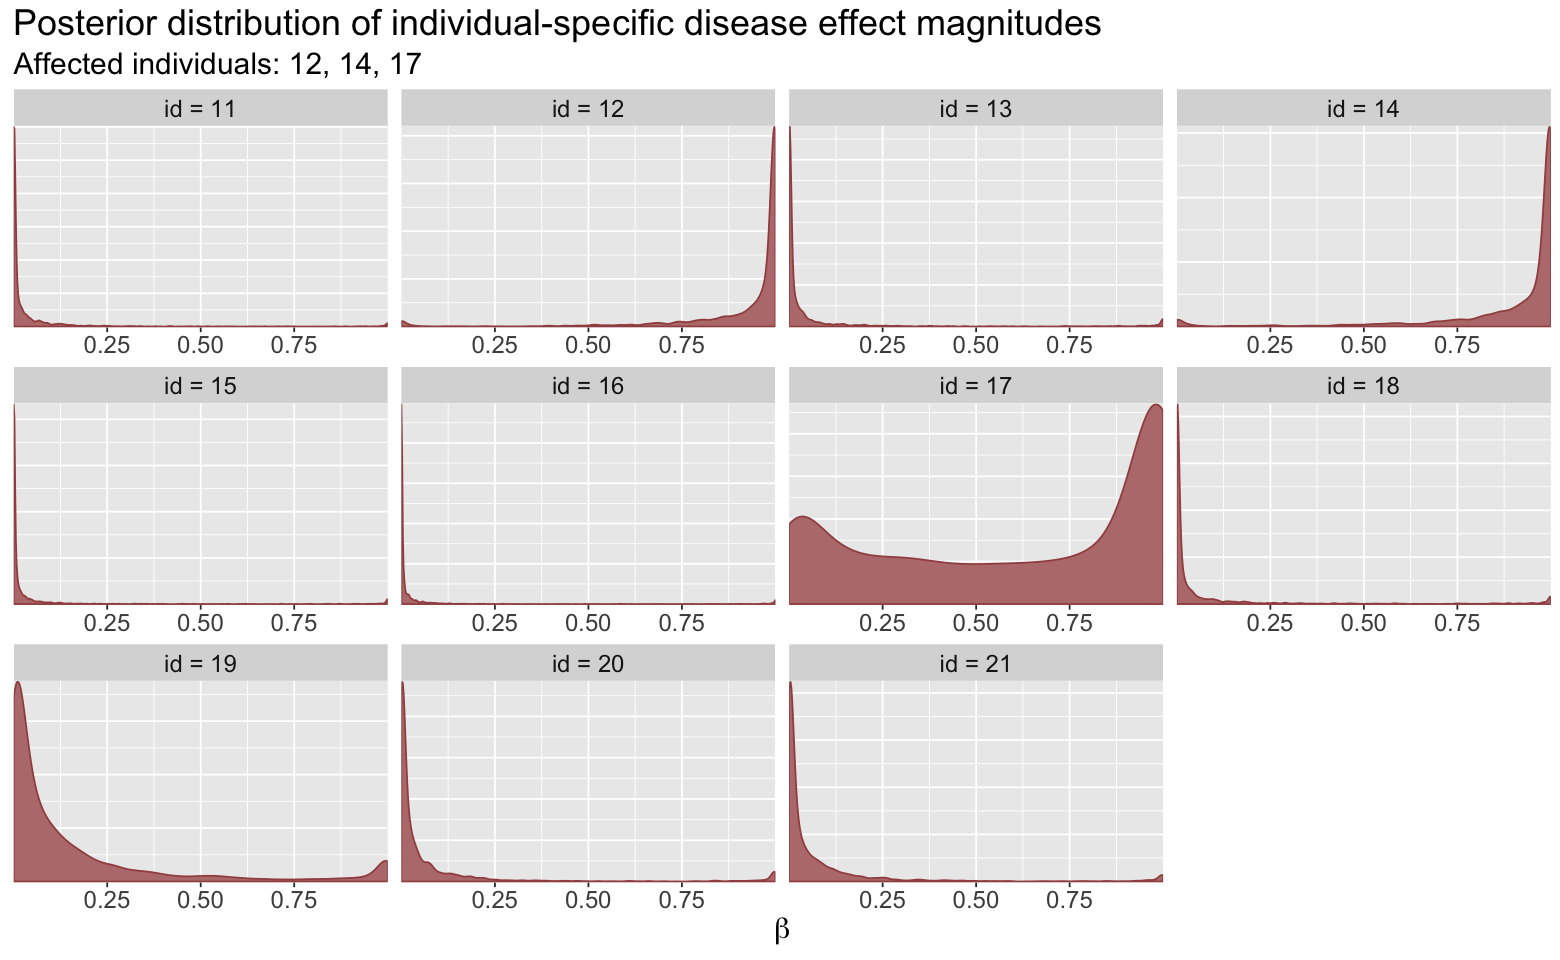

In [8]:
plot_beta(fit2) + theme(text=element_text(size=FONT_SIZE))

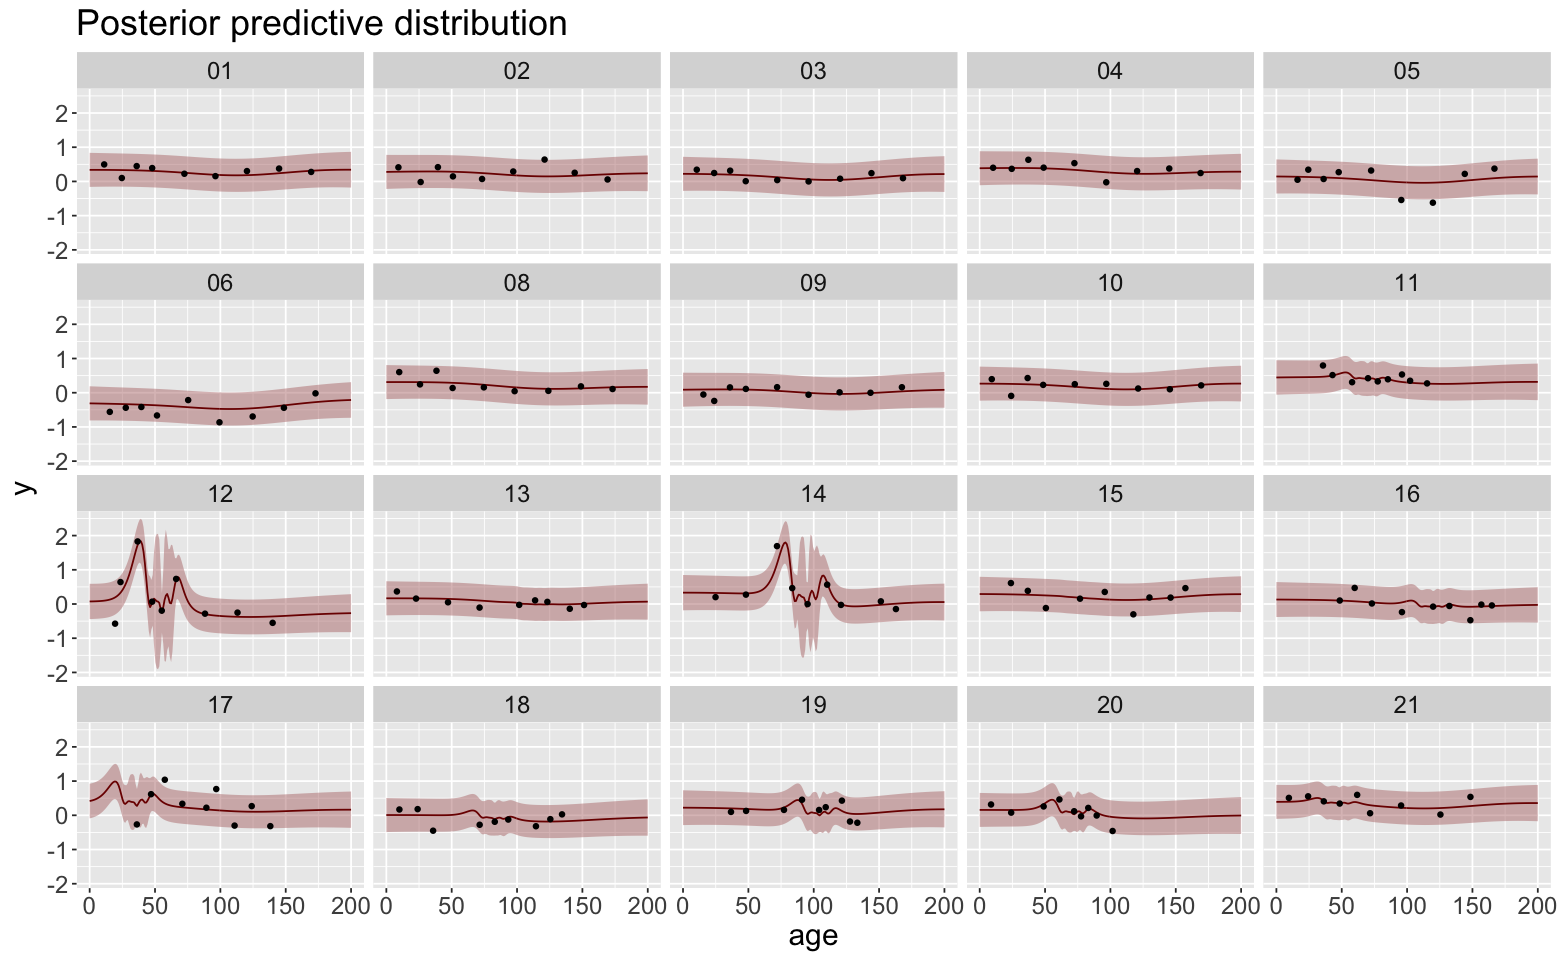

In [11]:
plot2b <- plot_posterior_y(fit2, PRED=PRED2) + theme(text=element_text(size=FONT_SIZE))
plot2b

## References
[1] Liu CW, Bramer L, Webb-Robertson BJ, Waugh K, Rewers MJ, Zhang Q. *Temporal expression profiling of plasma proteins reveals oxidative stress in early stages of Type 1 Diabetes progression.* J Proteomics. 2018;172:100–110. [doi:10.1016/j.jprot.2017.10.004]